# Import data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')

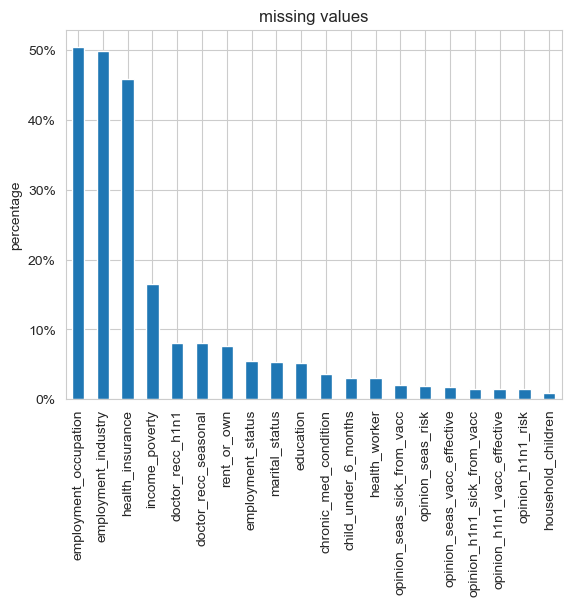

In [2]:
import matplotlib.ticker as mtick
# count missing values
df_missing_values_percentage =train_features.isnull().sum().sort_values(ascending=False)[:20]/len(train_features)
# draw missing values percentage bar chart
df_missing_values_percentage.plot(kind='bar')
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title('missing values')
plt.ylabel('percentage')
plt.show()

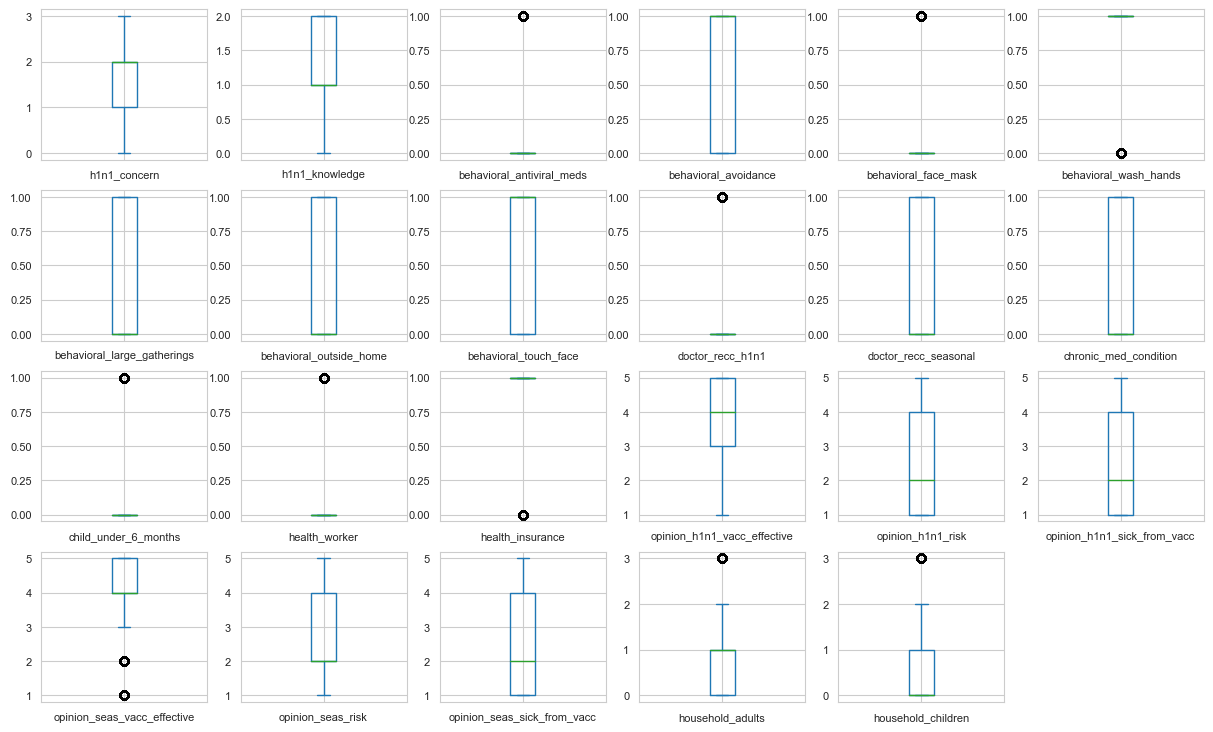

In [3]:
# draw 数值型特征的箱线图，排除respondent_id
numerical_columns = train_features.select_dtypes(include=['int64', 'float64']).columns.drop('respondent_id')
train_features[numerical_columns].plot(kind='box', subplots=True, layout=(4, 6), figsize=(15, 9), fontsize=8)
plt.show()

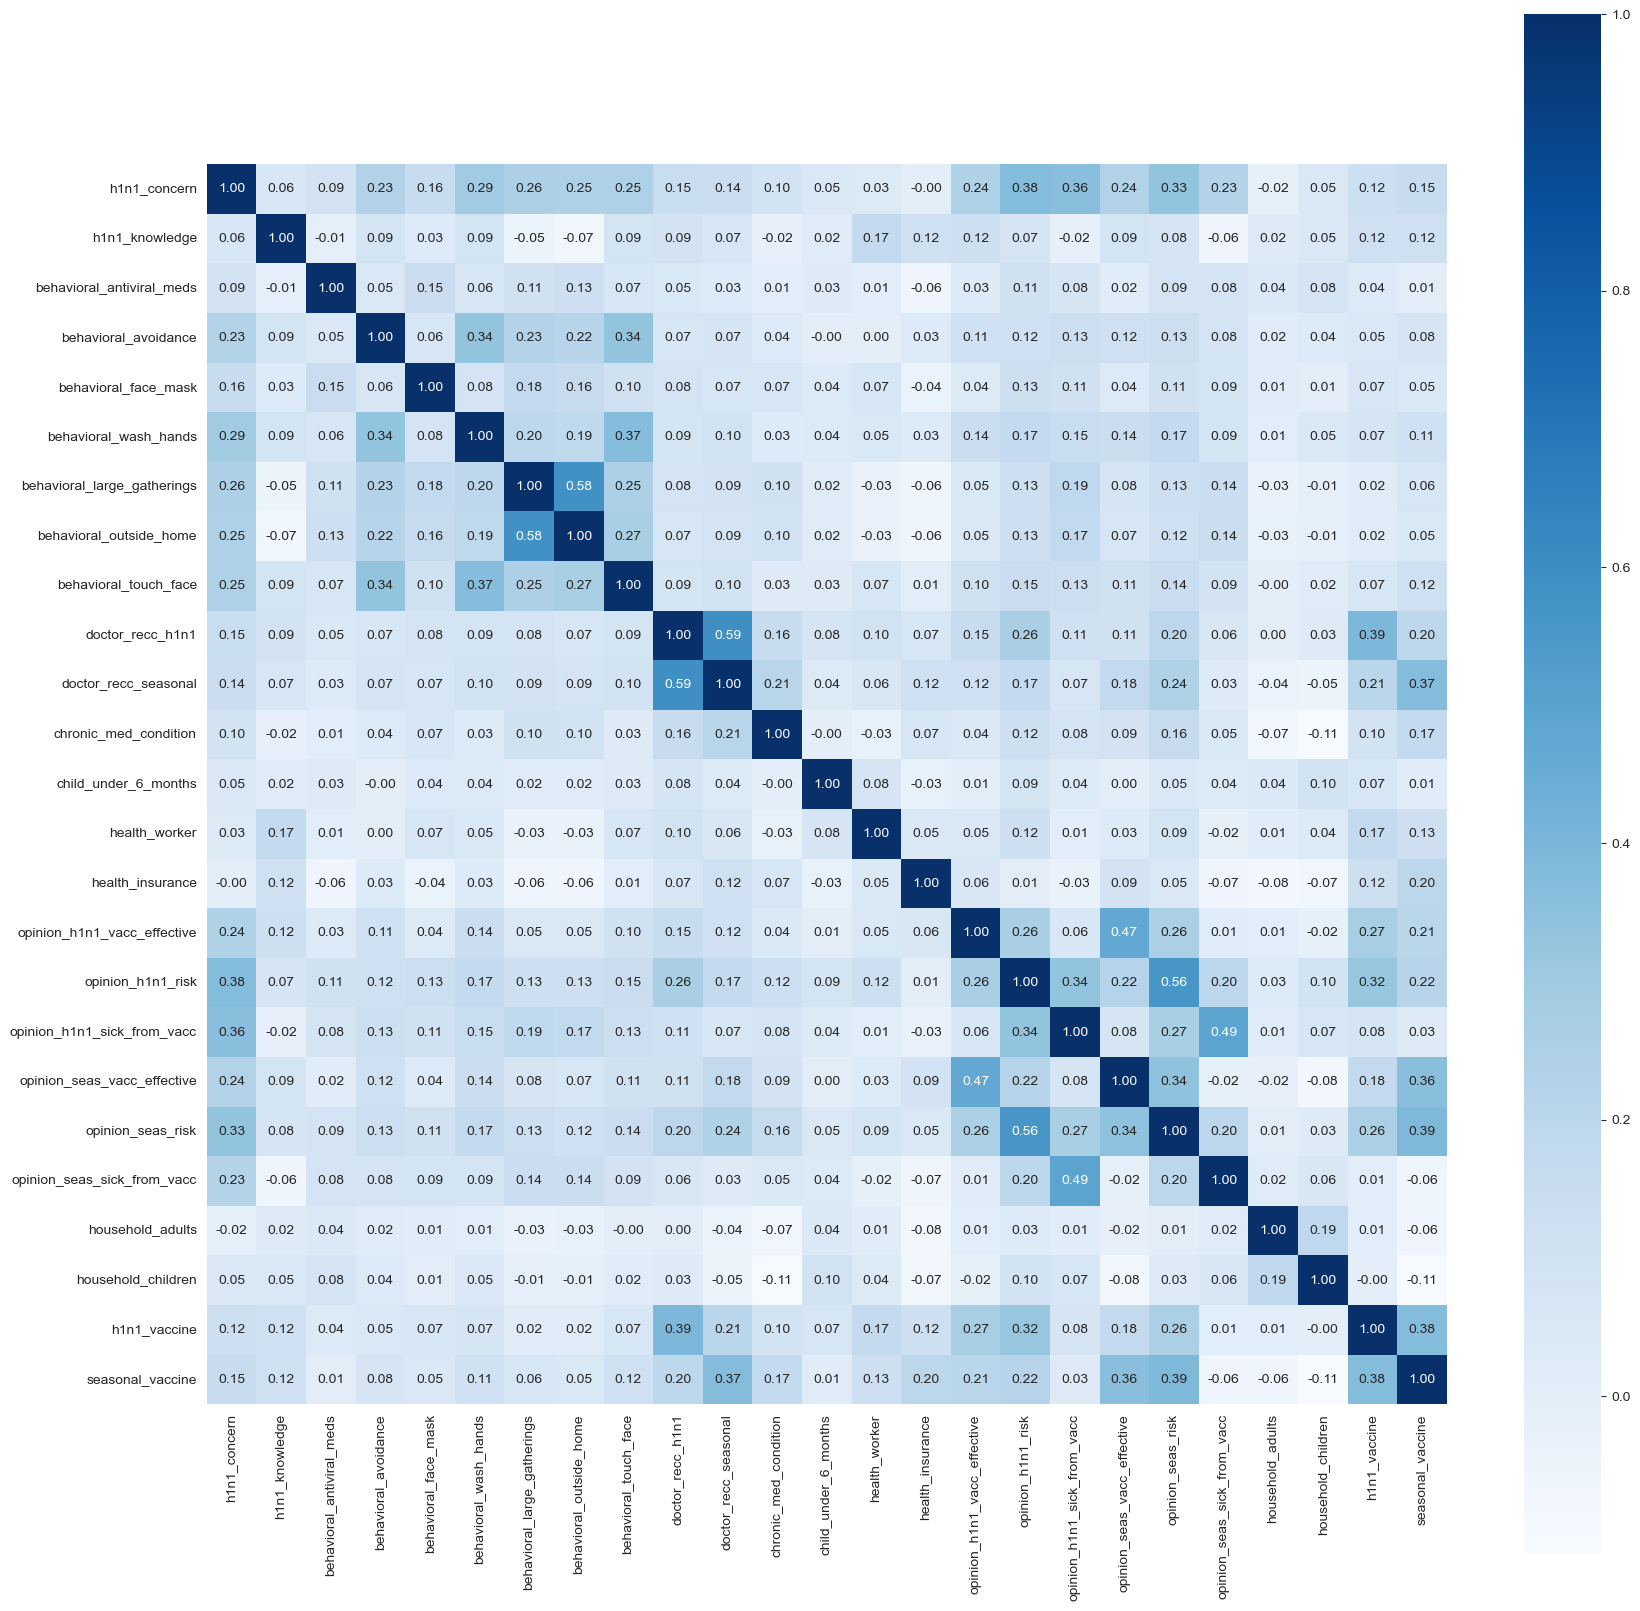

In [4]:
# 画出特征热图包括label中的两个特征，用红蓝色表示正负相关，只显示下三角
import seaborn as sns
heatmap_data = pd.concat([train_features, train_labels], axis=1).drop('respondent_id', axis=1)
plt.figure(figsize=(20, 20))
sns.heatmap(heatmap_data.corr(), annot=True, fmt='.2f', square=True, cmap='Blues')
plt.show()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Encode categorical variables
le = LabelEncoder()
feature_inportance = train_features.copy()
for column in feature_inportance.columns:
    if feature_inportance[column].dtype == 'object':
        feature_inportance[column] = feature_inportance[column].astype(str)
        feature_inportance[column] = le.fit_transform(feature_inportance[column])

# Impute missing values with the mean for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_columns = feature_inportance.select_dtypes(include=['int64', 'float64']).columns
feature_inportance[numerical_columns] = num_imputer.fit_transform(feature_inportance[numerical_columns])

# Function to calculate feature importances for a given target variable
def calculate_feature_importances(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    return pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Calculate feature importances for both target variables
importances_h1n1 = calculate_feature_importances(feature_inportance, train_labels['h1n1_vaccine'])
importances_seasonal = calculate_feature_importances(feature_inportance, train_labels['seasonal_vaccine'])

print("Feature importances for h1n1_vaccine:")
print(importances_h1n1)
print("Feature importances for seasonal_vaccine:")
print(importances_seasonal)

# Set a threshold for feature importance (you can adjust this value based on your specific problem)
threshold = 0.01

# Identify unimportant features
unimportant_features_h1n1 = importances_h1n1[importances_h1n1 < threshold].index
unimportant_features_seasonal = importances_seasonal[importances_seasonal < threshold].index
print("Unimportant features for h1n1_vaccine:")
print(unimportant_features_h1n1)
print("Unimportant features for seasonal_vaccine:")
print(unimportant_features_seasonal)

# Check if 'employment_industry', 'employment_occupation', and 'health_insurance' are unimportant
features_to_check = ['employment_industry', 'employment_occupation', 'health_insurance']
unimportant_checked_features_h1n1 = [feature for feature in features_to_check if feature in unimportant_features_h1n1]
unimportant_checked_features_seasonal = [feature for feature in features_to_check if feature in unimportant_features_seasonal]

if unimportant_checked_features_h1n1:
    print("Unimportant checked features for h1n1_vaccine:")
    print(unimportant_checked_features_h1n1)
else:
    print("All checked features are important for h1n1_vaccine.")

if unimportant_checked_features_seasonal:
    print("Unimportant checked features for seasonal_vaccine:")
    print(unimportant_checked_features_seasonal)
else:
    print("All checked features are important for seasonal_vaccine.")

Feature importances for h1n1_vaccine:
doctor_recc_h1n1               0.101279
respondent_id                  0.078692
opinion_h1n1_risk              0.069636
health_insurance               0.061872
opinion_h1n1_vacc_effective    0.055302
hhs_geo_region                 0.046420
opinion_seas_risk              0.040587
employment_occupation          0.038484
employment_industry            0.034149
age_group                      0.032126
opinion_h1n1_sick_from_vacc    0.027188
opinion_seas_vacc_effective    0.026801
h1n1_concern                   0.026715
education                      0.025987
opinion_seas_sick_from_vacc    0.024791
doctor_recc_seasonal           0.023216
census_msa                     0.022720
income_poverty                 0.022246
household_adults               0.021946
h1n1_knowledge                 0.020571
household_children             0.018375
health_worker                  0.016440
race                           0.016323
sex                            0.013946
ma

# Data preprocessing

In [6]:
def remove_outliers_iqr(data, columns):
    for column in columns:
        if data[column].dtype != 'object':
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

# 在训练集中移除离群值
train_data = remove_outliers_iqr(train_features, train_features.columns)

In [7]:
def preprocess_data(features, is_train=True, encoders=None):
    # 删除 'employment_industry', 'employment_occupation', and 'health_insurance' 三个特征
    # features.drop(['employment_industry', 'employment_occupation', 'health_insurance'], axis=1, inplace=True)
    # features.drop(['employment_industry', 'employment_occupation'], axis=1, inplace=True)

    # 处理缺失值
    features.fillna({'health_insurance': 0, 'child_under_6_months': 0}, inplace=True)
    features.fillna(features.mean(), inplace=True)
    features.fillna('unknown', inplace=True)

    # 标签编码
    label_columns = [
        'age_group',
        'education',
        'income_poverty',
        'h1n1_concern',
        'h1n1_knowledge',
        'opinion_h1n1_vacc_effective',
        'opinion_h1n1_risk',
        'opinion_h1n1_sick_from_vacc',
        'opinion_seas_vacc_effective',
        'opinion_seas_risk',
        'opinion_seas_sick_from_vacc',
    ]

    # 独热编码
    one_hot_columns = [
        'race',
        'sex',
        'marital_status',
        'rent_or_own',
        'employment_status',
        'hhs_geo_region',
        'census_msa',
        'employment_industry',
        'employment_occupation',
    ]

    if is_train:
        encoders = {}

        for column in label_columns:
            le = LabelEncoder()
            unique_values = features[column].unique().tolist()
            unique_values.append('unknown')
            le.fit(unique_values)
            features[column] = le.transform(features[column])
            encoders[column] = le

        ohe = OneHotEncoder(sparse=False)
        one_hot_encoded = ohe.fit_transform(features[one_hot_columns])
        encoders['one_hot'] = ohe
        features = features.drop(one_hot_columns, axis=1)
        features = pd.concat([features, pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(one_hot_columns))], axis=1)
    else:
        for column in label_columns:
            features[column] = features[column].apply(lambda x: x if x in encoders[column].classes_ else 'unknown')
            features[column] = encoders[column].transform(features[column])

        one_hot_encoded = encoders['one_hot'].transform(features[one_hot_columns])
        features = features.drop(one_hot_columns, axis=1)
        features = pd.concat([features, pd.DataFrame(one_hot_encoded, columns=encoders['one_hot'].get_feature_names_out(one_hot_columns))], axis=1)

    # 标准化数据
    numerical_columns = features.select_dtypes(include=['int64', 'float64']).columns
    if is_train:
        scaler = StandardScaler()
        features[numerical_columns] = scaler.fit_transform(features[numerical_columns])
        encoders['scaler'] = scaler
    else:
        features[numerical_columns] = encoders['scaler'].transform(features[numerical_columns])

    return features, encoders

# Construct neural network structure

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# 数据预处理
X_features, encoders = preprocess_data(train_features)
y_table_h1n1 = train_labels['h1n1_vaccine']
y_table_seasonal = train_labels['seasonal_vaccine']

# 划分训练集和验证集
X_train, X_val, y_train_h1n1, y_val_h1n1 = train_test_split(X_features, y_table_h1n1, test_size=0.2, random_state=42)
X_train, X_val, y_train_seasonal, y_val_seasonal = train_test_split(X_features, y_table_seasonal, test_size=0.2, random_state=42)

# param_grid = {
#     'hidden_layer_sizes': [(50, 50), (64, 64), (100, 100)],
#     'activation': ['relu', 'tanh', 'logistic'],
#     'solver': ['adam', 'sgd', 'lbfgs'],
#     'learning_rate_init': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'max_iter': [50, 100, 200]
# }
#
# mlp = MLPClassifier()
# grid_search = GridSearchCV(mlp, param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=2)
# grid_search = GridSearchCV(mlp, param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=2)
# grid_search.fit(X_train, y_train_h1n1)  # 对于 H1N1 疫苗
#
# # 通过访问 `grid_search.best_params_` 获取最佳参数组合
# print("Best parameters for H1N1 vaccine: ", grid_search.best_params_)
#
# grid_search.fit(X_train, y_train_seasonal) # 对于季节性流感疫苗
#
# # 通过访问 `grid_search.best_params_` 获取最佳参数组合
# print("Best parameters for seasonal flu vaccine: ", grid_search.best_params_)

/var/folders/n_/54212b493pd645vds1j7659c0000gn/T/ipykernel_38827/3239545396.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features.fillna(features.mean(), inplace=True)
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
model_h1n1 = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', learning_rate_init=0.0001, learning_rate='adaptive', alpha=0.0001, max_iter=50)
model_seasonal = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', learning_rate_init=0.0001, learning_rate='adaptive', alpha=0.0001, max_iter=50)

In [10]:
from sklearn.metrics import accuracy_score

# 分别训练两个模型
model_h1n1.fit(X_train, y_train_h1n1)
model_seasonal.fit(X_train, y_train_seasonal)

/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 64), learning_rate='adaptive',
              learning_rate_init=0.0001, max_iter=50)

In [11]:
from sklearn.model_selection import KFold, cross_val_score

# 设定k值
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# 对H1N1模型进行k-fold交叉验证
h1n1_scores = cross_val_score(model_h1n1, X_features, y_table_h1n1, cv=kfold)
print("H1N1模型的交叉验证平均得分: {:.4f}".format(h1n1_scores.mean()))

# 对季节性流感模型进行k-fold交叉验证
seasonal_scores = cross_val_score(model_seasonal, X_features, y_table_seasonal, cv=kfold)
print("季节性流感模型的交叉验证平均得分: {:.4f}".format(seasonal_scores.mean()))

/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/a

H1N1模型的交叉验证平均得分: 0.8492


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


季节性流感模型的交叉验证平均得分: 0.7734


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


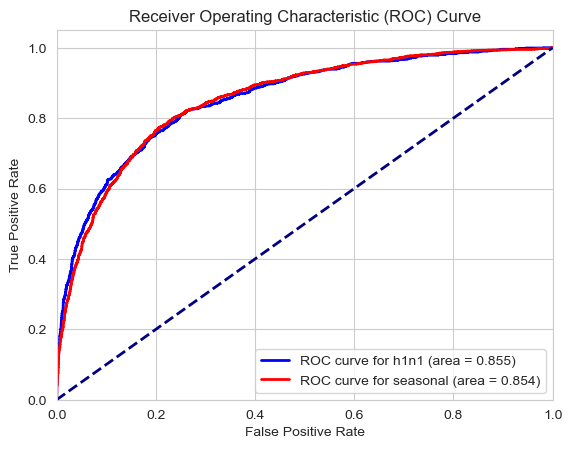

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob_h1n1 = model_h1n1.predict_proba(X_val)
y_prob_seasonal = model_seasonal.predict_proba(X_val)

# Compute ROC curve and ROC area for each target
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_val_h1n1, y_prob_h1n1[:, 1])
roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)

fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val_seasonal, y_prob_seasonal[:, 1])
roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

# Plot ROC curve for h1n1
plt.plot(fpr_h1n1, tpr_h1n1, color='b', lw=2, label=f'ROC curve for h1n1 (area = {roc_auc_h1n1:.3f})')

# Plot ROC curve for seasonal
plt.plot(fpr_seasonal, tpr_seasonal, color='r', lw=2, label=f'ROC curve for seasonal (area = {roc_auc_seasonal:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Ablation experiment

In [13]:
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)
    preds = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)
    return roc_auc, preds, fpr, tpr


def plot_roc_curves(ax, fpr_h1n1, tpr_h1n1, roc_auc_h1n1, fpr_seasonal, tpr_seasonal, roc_auc_seasonal, group_name):
    ax.plot(fpr_h1n1, tpr_h1n1, color='b', lw=2, label=f'ROC curve for h1n1 (area = {roc_auc_h1n1:.3f})')
    ax.plot(fpr_seasonal, tpr_seasonal, color='r', lw=2, label=f'ROC curve for seasonal (area = {roc_auc_seasonal:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) Curve\nExcluding {group_name}')
    ax.legend(loc="lower right")


def ablation_experiment(feature_groups, train_features, train_labels, model, k):
    best_auc_h1n1 = 0
    best_auc_seasonal = 0
    best_h1n1_model = None
    best_seasonal_model = None
    best_h1n1_preds = None
    best_seasonal_preds = None

    fig, axes = plt.subplots(nrows=1, ncols=len(feature_groups), figsize=(18, 6), sharey=True)
    fig.subplots_adjust(wspace=0.4)

    for idx, (group_name, feature_group) in enumerate(feature_groups.items()):
        print(f'Performing ablation experiment by excluding {group_name}...')
        features_to_remove = [col for col in feature_group if col in train_features.columns]
        features_filtered = train_features.drop(features_to_remove, axis=1)
        skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

        roc_data = []
        for target_label, color in zip(['h1n1_vaccine', 'seasonal_vaccine'], ['b', 'r']):
            print(f'Training and evaluating model for {target_label}...')
            aucs = []
            all_preds = []

            for train_index, val_index in skf.split(features_filtered, train_labels[target_label]):
                X_train, X_val = features_filtered.iloc[train_index], features_filtered.iloc[val_index]
                y_train, y_val = train_labels[target_label].iloc[train_index], train_labels[target_label].iloc[val_index]
                roc_auc, preds, fpr, tpr = train_and_evaluate_model(model, X_train, X_val, y_train, y_val)
                aucs.append(roc_auc)
                all_preds.extend(preds)

            mean_auc = np.mean(aucs)
            print(f'Average ROC AUC score for {target_label}: {mean_auc:.3f}')

            if target_label == 'h1n1_vaccine' and mean_auc > best_auc_h1n1:
                best_auc_h1n1 = mean_auc
                best_h1n1_model = model
                best_h1n1_preds = all_preds
            elif target_label == 'seasonal_vaccine' and mean_auc > best_auc_seasonal:
                best_auc_seasonal = mean_auc
                best_seasonal_model = model
                best_seasonal_preds = all_preds

            roc_data.append((fpr, tpr, roc_auc))

            # Calculate and display the classification report
            if target_label == 'h1n1_vaccine':
                print("Best H1N1 classification report:")
                print(classification_report(train_labels[target_label], best_h1n1_preds))
            elif target_label == 'seasonal_vaccine':
                print("Best Seasonal classification report:")
                print(classification_report(train_labels[target_label], best_seasonal_preds))
        # Plot ROC curves for each group in a subplot
        plot_roc_curves(axes[idx], *roc_data[0], *roc_data[1], group_name)

    plt.tight_layout()
    plt.show()

    return best_h1n1_model, best_seasonal_model

In [14]:
# Respondents' personal backgrounds
personal_backgrounds = [
    'respondent_id',
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    'employment_industry',
    'employment_occupation',
    'health_worker',
    'health_insurance',
    'chronic_med_condition',
    'child_under_6_months'
]

# Respondents' perceptions of vaccines
perceptions_of_vaccines = [
    'h1n1_concern',
    'h1n1_knowledge',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

# Respondents' daily behaviors
daily_behaviors = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
]

In [15]:
train_features_processed, encoders = preprocess_data(train_features, is_train=True)
test_features_processed, _ = preprocess_data(test_features, is_train=False, encoders=encoders)
one_hot_encoder = encoders['one_hot']

# 获取One-Hot编码后的列名
one_hot_columns = one_hot_encoder.get_feature_names_out(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']).tolist()

# one_hot_columns = one_hot_encoder.get_feature_names_out(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa']).tolist()

# 更新 Respondents' personal backgrounds
personal_backgrounds_one_hot = [col for col in one_hot_columns if col.startswith(tuple(personal_backgrounds))]
personal_backgrounds_updated = personal_backgrounds + personal_backgrounds_one_hot

feature_groups = {
    "Respondents' personal backgrounds": personal_backgrounds_updated,
    "Respondents' perceptions of vaccines": perceptions_of_vaccines,
    "Respondents' daily behaviors": daily_behaviors
}

/var/folders/n_/54212b493pd645vds1j7659c0000gn/T/ipykernel_38827/3239545396.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features.fillna(features.mean(), inplace=True)
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/n_/54212b493pd645vds1j7659c0000gn/T/ipykernel_38827/3239545396.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features.fillna(features.mean(), inplace=True)
/var/folders/n_/54212b4

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/a

Average ROC AUC score for h1n1_vaccine: 0.821
Best H1N1 classification report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     21033
           1       0.21      0.14      0.17      5674

    accuracy                           0.71     26707
   macro avg       0.50      0.50      0.49     26707
weighted avg       0.66      0.71      0.68     26707

Training and evaluating model for seasonal_vaccine...


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/a

Average ROC AUC score for seasonal_vaccine: 0.825
Best Seasonal classification report:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55     14272
           1       0.47      0.45      0.46     12435

    accuracy                           0.51     26707
   macro avg       0.50      0.50      0.50     26707
weighted avg       0.51      0.51      0.51     26707

Performing ablation experiment by excluding Respondents' perceptions of vaccines...
Training and evaluating model for h1n1_vaccine...


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/a

Average ROC AUC score for h1n1_vaccine: 0.731
Best H1N1 classification report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     21033
           1       0.21      0.14      0.17      5674

    accuracy                           0.71     26707
   macro avg       0.50      0.50      0.49     26707
weighted avg       0.66      0.71      0.68     26707

Training and evaluating model for seasonal_vaccine...


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/a

Average ROC AUC score for seasonal_vaccine: 0.728
Best Seasonal classification report:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55     14272
           1       0.47      0.45      0.46     12435

    accuracy                           0.51     26707
   macro avg       0.50      0.50      0.50     26707
weighted avg       0.51      0.51      0.51     26707

Performing ablation experiment by excluding Respondents' daily behaviors...
Training and evaluating model for h1n1_vaccine...


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/a

Average ROC AUC score for h1n1_vaccine: 0.852
Best H1N1 classification report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     21033
           1       0.21      0.15      0.17      5674

    accuracy                           0.70     26707
   macro avg       0.50      0.50      0.49     26707
weighted avg       0.66      0.70      0.68     26707

Training and evaluating model for seasonal_vaccine...


/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/solidus/opt/a

Average ROC AUC score for seasonal_vaccine: 0.850
Best Seasonal classification report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.54     14272
           1       0.47      0.46      0.46     12435

    accuracy                           0.51     26707
   macro avg       0.50      0.50      0.50     26707
weighted avg       0.51      0.51      0.51     26707



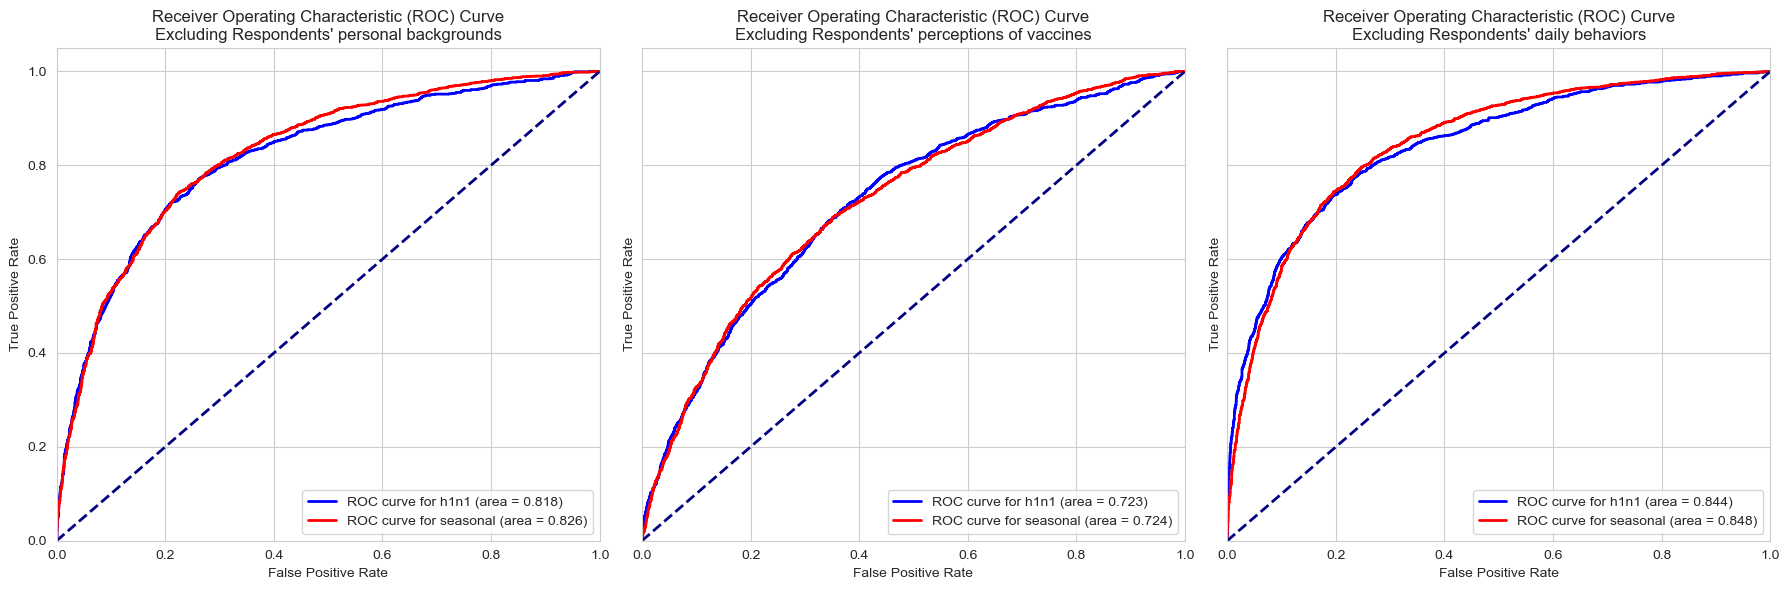

In [16]:
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', learning_rate_init=0.0001, learning_rate='adaptive', alpha=0.0001, max_iter=50)

best_h1n1_model, best_seasonal_model = ablation_experiment(feature_groups, train_features_processed, train_labels, model, 5)